<a href="https://colab.research.google.com/github/ad3707/H4D/blob/main/Copy_of_Retrain_Object_Detection_ssd_mobilenetv2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction


In this notebook, we implement [The TensorFlow 2 Object Detection Library](https://blog.tensorflow.org/2020/07/tensorflow-2-meets-object-detection-api.html) for training on your own dataset.


We will take the following steps to implement mobilenetV2 on our custom data:
* Install TensorFlow2 Object Detection Dependencies
* Download Custom TensorFlow2 Object Detection Dataset
* Write Custom TensorFlow2 Object Detection Training Configuation
* Train Custom TensorFlow2 Object Detection Model
* Export Custom TensorFlow2 Object Detection Weights
* Use Trained TensorFlow2 Object Detection For Inference on Test Images

When you are done you will have a custom detector that you can use. 

# Install TensorFlow2 Object Detection Dependencies

In [1]:
#Clone rep of TensorFlow object detection api 
import os
import pathlib

%cd /content/

# Clone the tensorflow models repository if it doesn't already exist
if "models" in pathlib.Path.cwd().parts:
  while "models" in pathlib.Path.cwd().parts:
    os.chdir('..')
elif not pathlib.Path('models').exists():
  !git clone --depth 1 https://github.com/tensorflow/models

/content
Cloning into 'models'...
remote: Enumerating objects: 3135, done.
remote: Counting objects: 100% (3135/3135), done.
remote: Compressing objects: 100% (2647/2647), done.
remote: Total 3135 (delta 809), reused 1346 (delta 444), pack-reused 0
Receiving objects: 100% (3135/3135), 33.35 MiB | 17.09 MiB/s, done.
Resolving deltas: 100% (809/809), done.


In [ ]:
# Install the Object Detection API
%%bash
cd /content/models/research/
protoc object_detection/protos/*.proto --python_out=.
cp object_detection/packages/tf2/setup.py .
python -m pip install .

In [ ]:
import matplotlib
import matplotlib.pyplot as plt

import os
import random
import io
import imageio
import glob
import scipy.misc
import numpy as np
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont
from IPython.display import display, Javascript
from IPython.display import Image as IPyImage

import tensorflow as tf

from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.utils import colab_utils
from object_detection.builders import model_builder

%matplotlib inline

In [ ]:
#run model builder test
!python /content/models/research/object_detection/builders/model_builder_tf2_test.py


2021-01-13 09:04:16.179085: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
Running tests under Python 3.6.9: /usr/bin/python3
[ RUN      ] ModelBuilderTF2Test.test_create_center_net_model
2021-01-13 09:04:19.206994: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-01-13 09:04:19.208369: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-01-13 09:04:19.257391: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-01-13 09:04:19.258232: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla K80 computeCapability: 3.7
coreClock: 0.8235GHz coreCount: 13 deviceMemorySize: 11.17GiB de

# Prepare Tensorflow 2 Object Detection Training Data

> 



We are going to use Roboflow to generate image data set and convert it to TFrecords format.

To create a dataset in Roboflow and generate TFRecords, follow [this step-by-step guide](https://blog.roboflow.ai/getting-started-with-roboflow/).




In [ ]:
#Downloading data Training set made by Roboflow
%cd /content

#Download Training set from git by cloning rep:
import os
import pathlib
# Clone the training set repository if it doesn't already exist
if "RetrainModelExample" in pathlib.Path.cwd().parts:
  while "RetrainModelExample" in pathlib.Path.cwd().parts:
    os.chdir('..')
elif not pathlib.Path('RetrainModelExample').exists():
  !git clone --depth 1 https://github.com/KostaMalsev/RetrainModelExample
  %cd /content/RetrainModelExample/TrainingSet/Picka 
  !unzip Pickachu2.v1.tfrecord.zip -d /content/

#NOTE: Update these TFRecord names to your files containing training set!
#Also, Update relevant rows:in training config file "ssd_mobilenet_v2_320x320_coco17_tpu-8.config"
#label_map_path,input_path 
test_record_fname = '/content/valid/Toy.tfrecord'
train_record_fname = '/content/train/Toy.tfrecord'
label_map_pbtxt_fname = '/content/train/Toy_label_map.pbtxt'

#test_record_fname = '/content/valid/pieces.tfrecord'
#train_record_fname = '/content/train/toymnm.tfrecord'
#label_map_pbtxt_fname = '/content/train/toymnm_label_map.pbtxt'


/content
Cloning into 'RetrainModelExample'...
remote: Enumerating objects: 22, done.
remote: Counting objects: 100% (22/22), done.
remote: Compressing objects: 100% (21/21), done.
remote: Total 22 (delta 2), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (22/22), done.
/content/RetrainModelExample/TrainingSet/Picka
Archive:  Pickachu2.v1.tfrecord.zip
 extracting: /content/README.roboflow.txt  
   creating: /content/train/
 extracting: /content/train/Toy.tfrecord  
 extracting: /content/train/Toy_label_map.pbtxt  


# Configure Custom TensorFlow2 Object Detection Training 




> In this section we specify configuration for mobilentV2 model. for additional models see [TF2 OD model zoo](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/tf2_detection_zoo.md).



In [ ]:
#We choose mobilentv2 model to deploy from TF2 object detection zoo
MODELS_CONFIG = {
    'ssd_mobilenet_v2_320x320_coco17': {
        'model_name': 'ssd_mobilenet_v2_320x320_coco17_tpu-8',
        'base_pipeline_file': 'ssd_mobilenet_v2_320x320_coco17_tpu-8.config',
        'pretrained_checkpoint': 'ssd_mobilenet_v2_320x320_coco17_tpu-8.tar.gz',
        'batch_size': 16
    }
}
#'batchsize 512 19/10/20
chosen_model = 'ssd_mobilenet_v2_320x320_coco17'

num_steps = 1800 #40000 #The more steps, the longer the training. Increase if your loss function is still decreasing and validation metrics are increasing. 
num_eval_steps = 500 #Perform evaluation after so many steps

model_name = MODELS_CONFIG[chosen_model]['model_name']
pretrained_checkpoint = MODELS_CONFIG[chosen_model]['pretrained_checkpoint']
batch_size = MODELS_CONFIG[chosen_model]['batch_size'] #if you can fit a large batch in memory, it may speed up your trainin#g
#base_pipeline_file = MODELS_CONFIG[chosen_model]['base_pipeline_file']

In [ ]:
#Download pretrained weights
%mkdir /content/deploy/
%cd /content/deploy/
import tarfile
download_tar = 'http://download.tensorflow.org/models/object_detection/tf2/20200711/' + pretrained_checkpoint

!wget {download_tar}
tar = tarfile.open(pretrained_checkpoint)
tar.extractall()
tar.close()
#Shorten the folder name,because long file paths are not yet supported :(
os.rename('ssd_mobilenet_v2_320x320_coco17_tpu-8','mobilnetv2')

/content/deploy
--2021-01-13 09:05:24--  http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v2_320x320_coco17_tpu-8.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 74.125.133.128, 2a00:1450:400c:c07::80
Connecting to download.tensorflow.org (download.tensorflow.org)|74.125.133.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 46042990 (44M) [application/x-tar]
Saving to: ‘ssd_mobilenet_v2_320x320_coco17_tpu-8.tar.gz’

ssd_mobilenet_v2_32 100%[===================>]  43.91M  5.39MB/s    in 7.7s    

2021-01-13 09:05:33 (5.68 MB/s) - ‘ssd_mobilenet_v2_320x320_coco17_tpu-8.tar.gz’ saved [46042990/46042990]



In [ ]:
#Download training configuration file for mobilenetV2. 
#note: configuration file contain references to your trainig set of images,
#you can change it for your dataset.
%cd /content/deploy
download_config = 'https://raw.githubusercontent.com/KostaMalsev/RetrainModelExample/main/ssd_mobilenet_v2_320x320_coco17_tpu-8.config'
!wget {download_config}

/content/deploy
--2021-01-13 09:05:37--  https://raw.githubusercontent.com/KostaMalsev/RetrainModelExample/main/ssd_mobilenet_v2_320x320_coco17_tpu-8.config
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4737 (4.6K) [text/plain]
Saving to: ‘ssd_mobilenet_v2_320x320_coco17_tpu-8.config’

ssd_mobilenet_v2_32 100%[===================>]   4.63K  --.-KB/s    in 0s      

2021-01-13 09:05:38 (57.4 MB/s) - ‘ssd_mobilenet_v2_320x320_coco17_tpu-8.config’ saved [4737/4737]



In [ ]:
#Prepare loaded model for retraining
fine_tune_checkpoint = '/content/deploy/mobilnetv2/checkpoint/ckpt-0'
pipeline_file = '/content/deploy/ssd_mobilenet_v2_320x320_coco17_tpu-8.config'
model_dir = '/content/training/'

def get_num_classes(pbtxt_fname):
    from object_detection.utils import label_map_util
    label_map = label_map_util.load_labelmap(pbtxt_fname)
    categories = label_map_util.convert_label_map_to_categories(
        label_map, max_num_classes=90, use_display_name=True)
    category_index = label_map_util.create_category_index(categories)
    return len(category_index.keys())
num_classes = get_num_classes(label_map_pbtxt_fname)


In [ ]:
#Check if all configuration is OK:
print(fine_tune_checkpoint)
print(train_record_fname)
print(label_map_pbtxt_fname)
print(batch_size)
print(num_steps)
print(num_classes)
print(pipeline_file)
print(model_dir)

/content/deploy/mobilnetv2/checkpoint/ckpt-0
/content/train/Toy.tfrecord
/content/train/Toy_label_map.pbtxt
16
1800
1
/content/deploy/ssd_mobilenet_v2_320x320_coco17_tpu-8.config
/content/training/


# Train Custom TF2 Object Detector

* pipeline_file: defined above in writing custom training configuration
* model_dir: the location tensorboard logs and saved model checkpoints will save to
* num_train_steps: how long to train for
* num_eval_steps: perform eval on validation set after this many steps







In [ ]:
!python /content/models/research/object_detection/model_main_tf2.py \
    --pipeline_config_path={pipeline_file} \
    --model_dir={model_dir} \
    --alsologtostderr \
    --num_train_steps={num_steps} \
    --sample_1_of_n_eval_examples=1 \
    --num_eval_steps={num_eval_steps}

2021-01-13 09:06:10.544002: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2021-01-13 09:06:13.581979: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-01-13 09:06:13.583201: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-01-13 09:06:13.607112: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-01-13 09:06:13.607878: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla K80 computeCapability: 3.7
coreClock: 0.8235GHz coreCount: 13 deviceMemorySize: 11.17GiB deviceMemoryBandwidth: 223.96GiB/s
2021-01-13 09:06:13.607927: I tensorflow/stream_executor/platform/default/dso_lo

In [ ]:
#Your trained weights will be in this directory:
%ls -l '/content/training/'

total 54556
-rw-r--r-- 1 root root      253 Jan 13 09:15 checkpoint
-rw-r--r-- 1 root root 18649245 Jan 13 09:07 ckpt-1.data-00000-of-00001
-rw-r--r-- 1 root root    22263 Jan 13 09:07 ckpt-1.index
-rw-r--r-- 1 root root 37130901 Jan 13 09:15 ckpt-2.data-00000-of-00001
-rw-r--r-- 1 root root    41640 Jan 13 09:15 ckpt-2.index
drwxr-xr-x 2 root root     4096 Jan 13 09:06 train/


In [ ]:
#Run conversion script to save the retrained model:
#Saved model will be in saved_model.pb file:

import re
import numpy as np

output_directory = '/content/fine_tuned_model'

#place the model weights you would like to export here
last_model_path = '/content/training/'
print(last_model_path)
!python /content/models/research/object_detection/exporter_main_v2.py \
    --trained_checkpoint_dir {last_model_path} \
    --output_directory {output_directory} \
    --pipeline_config_path {pipeline_file}

/content/training/
2021-01-13 09:30:54.667468: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2021-01-13 09:30:57.471160: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-01-13 09:30:57.472317: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-01-13 09:30:57.492921: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-01-13 09:30:57.493661: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla K80 computeCapability: 3.7
coreClock: 0.8235GHz coreCount: 13 deviceMemorySize: 11.17GiB deviceMemoryBandwidth: 223.96GiB/s
2021-01-13 09:30:57.493701: I tensorflow/stream_executor/plat

In [ ]:
%ls '/content/fine_tuned_model/saved_model/'

assets/  saved_model.pb  variables/


# Run Inference on Test Images with Custom TensorFlow2 Object Detector

In [ ]:
#Import your test images to colab. I use pinterest to store the the images. 
%mkdir /content/test/
%cd /content/test/
#M&M toy:
#!curl -L "https://i.pinimg.com/originals/4c/6a/00/4c6a0021a735e1dcb9edcb6715467e15.jpg" > test.jpeg;
#Pickachu toy:
!curl -L "https://i.pinimg.com/564x/f5/46/c4/f546c47505e1f5f8d17f8458d641b262.jpg" > test.jpeg;


/content/test
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 66488  100 66488    0     0   226k      0 --:--:-- --:--:-- --:--:--  226k


In [ ]:
import os 
import glob
import matplotlib
import matplotlib.pyplot as plt

import io
import scipy.misc
import numpy as np
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont

import tensorflow as tf

from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder

%matplotlib inline

In [ ]:
#Recover our saved model with the latest checkpoint:
pipeline_config = pipeline_file
#Put the last ckpt from training in here, don't use long pathnames:
model_dir = '/content/training/ckpt-2'
configs = config_util.get_configs_from_pipeline_file(pipeline_config)
model_config = configs['model']
detection_model = model_builder.build(
      model_config=model_config, is_training=False)

# Restore last checkpoint
ckpt = tf.compat.v2.train.Checkpoint(
      model=detection_model)
#ckpt.restore(os.path.join(model_dir))
ckpt.restore(model_dir)

#Function perform detection of the object on image in tensor format: 
def get_model_detection_function(model):
  """Get a tf.function for detection."""

  @tf.function
  def detect_fn(image):
    """Detect objects in image."""
    image, shapes = model.preprocess(image)
    prediction_dict = model.predict(image, shapes)
    detections = model.postprocess(prediction_dict, shapes)

    return detections, prediction_dict, tf.reshape(shapes, [-1])

  return detect_fn
  
#Define function which performs detection: 
detect_fn = get_model_detection_function(detection_model)

In [ ]:
#map labels for inference decoding
label_map_path = configs['eval_input_config'].label_map_path
label_map = label_map_util.load_labelmap(label_map_path)
categories = label_map_util.convert_label_map_to_categories(
    label_map,
    max_num_classes=label_map_util.get_max_label_map_index(label_map),
    use_display_name=True)
category_index = label_map_util.create_category_index(categories)
label_map_dict = label_map_util.get_label_map_dict(label_map, use_display_name=True)

INFO:tensorflow:depth of additional conv before box predictor: 0
INFO:tensorflow:depth of additional conv before box predictor: 0
INFO:tensorflow:depth of additional conv before box predictor: 0
INFO:tensorflow:depth of additional conv before box predictor: 0
INFO:tensorflow:depth of additional conv before box predictor: 0
INFO:tensorflow:depth of additional conv before box predictor: 0


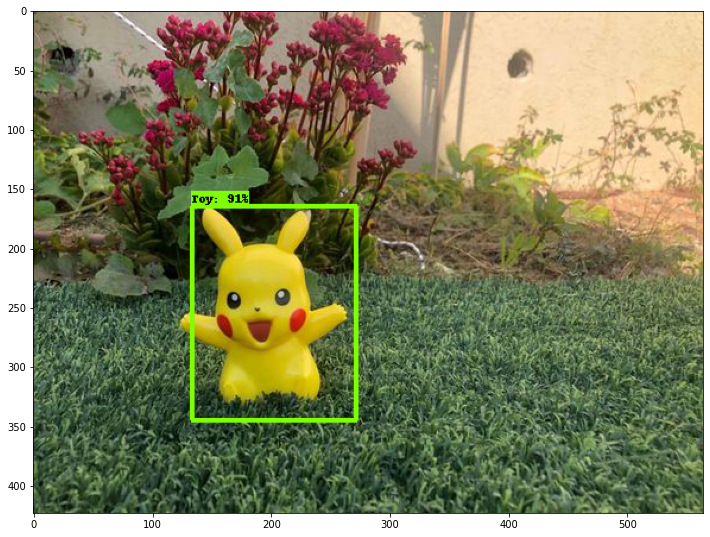

In [ ]:
#run detector on test image
#it takes a little longer on the first run and then runs at normal speed. 
import random

#Define utility functions for presenting the results:
def load_image_into_numpy_array(path):
  """Load an image from file into a numpy array.
  Puts image into numpy array to feed into tensorflow graph.
  Note that by convention we put it into a numpy array with shape
  (height, width, channels), where channels=3 for RGB.
  Args:
    path: the file path to the image
  Returns:
    uint8 numpy array with shape (img_height, img_width, 3)
  """
  img_data = tf.io.gfile.GFile(path, 'rb').read()
  image = Image.open(BytesIO(img_data))
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)


#Place your test images here:
image_path = '/content/test/test.jpeg'

#Store test images in nmpy array:
image_np = load_image_into_numpy_array(image_path)

#Convert images to tensor form:
input_tensor = tf.convert_to_tensor(
    np.expand_dims(image_np, 0), dtype=tf.float32)

#Perform detection on the image in tensor format:
detections, predictions_dict, shapes = detect_fn(input_tensor)

#Visualize the detection boxes on the image:
label_id_offset = 1
image_np_with_detections = image_np.copy()

viz_utils.visualize_boxes_and_labels_on_image_array(
      image_np_with_detections,
      detections['detection_boxes'][0].numpy(),
      (detections['detection_classes'][0].numpy() + label_id_offset).astype(int),
      detections['detection_scores'][0].numpy(),
      category_index,
      use_normalized_coordinates=True,
      max_boxes_to_draw=200,
      min_score_thresh=0.70,#0.5,#0.5
      agnostic_mode=False,
)

plt.figure(figsize=(12,16))
plt.imshow(image_np_with_detections)
plt.show()

In [ ]:
print(detections)

{'detection_boxes': <tf.Tensor: shape=(1, 100, 4), dtype=float32, numpy=
array([[[0.        , 0.5384983 , 0.8673439 , 1.        ],
        [0.06221145, 0.0056223 , 0.8854016 , 0.25180617],
        [0.38846886, 0.231343  , 0.79521966, 0.4667509 ],
        [0.18573296, 0.59499484, 1.        , 1.        ],
        [0.4002268 , 0.        , 0.998803  , 0.35892016],
        [0.00523809, 0.        , 0.7317513 , 0.39898866],
        [0.        , 0.44331908, 0.45566368, 1.        ],
        [0.5748647 , 0.5584329 , 1.        , 0.9606729 ],
        [0.        , 0.21766928, 0.6137232 , 1.        ],
        [0.44021353, 0.1027469 , 1.        , 1.        ],
        [0.45164448, 0.1844042 , 0.75729114, 0.5074981 ],
        [0.44310138, 0.27960944, 0.96253586, 0.700312  ],
        [0.05797669, 0.13167095, 0.7140225 , 0.83621466],
        [0.37078822, 0.182004  , 0.6741077 , 0.52983606],
        [0.36808866, 0.        , 0.9767062 , 0.13438487],
        [0.        , 0.642269  , 0.6422963 , 0.9904635 ],

# Congrats!
Hope you enjoyed this!

# Bonus level:

To use this retrained model in web browser run the following commands:

For details see my article on medium: 

"[Build custom object detection web application using TensorFlow.js](https://kostya-malsev.medium.com/build-custom-object-detection-web-application-using-tensorflow-js-d1664f96a18b)"


In [ ]:
!saved_model_cli show --dir /content/fine_tuned_model/saved_model/ --tag_set serve --signature_def serving_default


In [ ]:
!pip install tensorflowjs

In [ ]:
!tensorflowjs_converter  \
--input_format=tf_saved_model\
 --output_node_names='detection_boxes,detection_classes,detection_features,detection_multiclass_scores,detection_scores,num_detections,raw_detection_boxes,raw_detection_scores'\
  --saved_model_tags=serve\
   --output_format=tfjs_graph_model /content/fine_tuned_model/saved_model /content/fine_tuned_model/web_model/

In [ ]:
!ls /content/fine_tuned_model/

checkpoint  pipeline.config  saved_model  web_model
